# Objectives

In the KITTI dataset, sequence 07, the performance of the sensor fusion algorithm is degraded in the middle of the trajectory while fusing IMU and VO data. The sudden estimation spikes happens from nowhere and hard to identify the issues.

<img src="/Volumes/Data_EXT/data/workspaces/sensor_fusion/outputs/experiments/KITTI/visualization/1755357626342786/frames/output.png" height=600 width=900 />

### Action plan:
- [] Visualize IMU acceleration, gyro scope and VO velocity
- [] Monitor filter internals
- [] Isolate subsystem by running IMU dead reckoning and VO-only odometry without fusing
- [] Check timestamps and synchronization
- [] Verify correct frame transformations

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import Image

sys.path.append('/app/src')

from src.internal.extended_common import (
    CoordinateFrame,
    Pose, State,
    ExtendedConfig
)
from src.internal.dataset import OXTS_GPSDataReader
from src.common.datatypes import State, Pose
from src.utils.geometric_transformer import GeometryTransformer, TransformationField

warnings.filterwarnings("ignore")

In [2]:
raw_data_dir = "/app/outputs/sensor_data/1755438937/raw_sensor_data.csv"
data_dir = "/app/outputs/sensor_data/1755438937/sensor_data.csv"

raw_df = pd.read_csv(raw_data_dir)
df = pd.read_csv(data_dir)

In [24]:
raw_df['time'] = raw_df['timestamp'].subtract(raw_df['timestamp'].min())
df['time'] = df['timestamp'].subtract(df['timestamp'].min())

In [25]:
df.head()

,timestamp,type,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,gps_x,gps_y,...,vo_5,vo_6,vo_7,vo_8,vo_9,vo_10,vo_11,lat_vel,upward_vel,time
0,1.317376e+09,OXTS_IMU,0.355224,0.155038,9.749412,-0.004771,0.003257,0.060162,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1.317376e+09,KITTI_VO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999980,0.000862,0.192343,0.000197,-0.000864,1.0,-0.047295,NaN,NaN,0.000000
2,1.317376e+09,OXTS_IMU,0.404561,0.726865,9.942158,-0.004901,-0.001194,0.066461,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.109937
3,1.317376e+09,KITTI_VO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999974,0.000445,0.041454,0.000202,-0.000447,1.0,-0.028713,NaN,NaN,0.109937
4,1.317376e+09,OXTS_IMU,0.263863,-0.008678,9.918353,-0.002897,-0.005462,0.072469,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.209930


## Visualization of IMU and VO data

#### IMU data

In [26]:
condition = raw_df['type'] == "OXTS_IMU"
raw_imu = raw_df[condition][['timestamp', 'time', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
imu = df[condition][['timestamp', 'time', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]

In [27]:
imu.head()

,timestamp,time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
2,1.317376e+09,0.109937,0.404561,0.726865,9.942158,-0.004901,-0.001194,0.066461
6,1.317376e+09,0.310064,-0.131122,0.073138,9.832862,-0.005029,-0.011652,0.086731
10,1.317376e+09,0.519911,0.504361,-0.268154,9.437357,0.001428,-0.009175,0.127591
14,1.317376e+09,0.729968,1.103267,0.316009,9.802180,0.013469,0.000660,0.177093
18,1.317376e+09,0.939950,0.954396,1.073283,9.636391,0.001665,-0.000700,0.213429


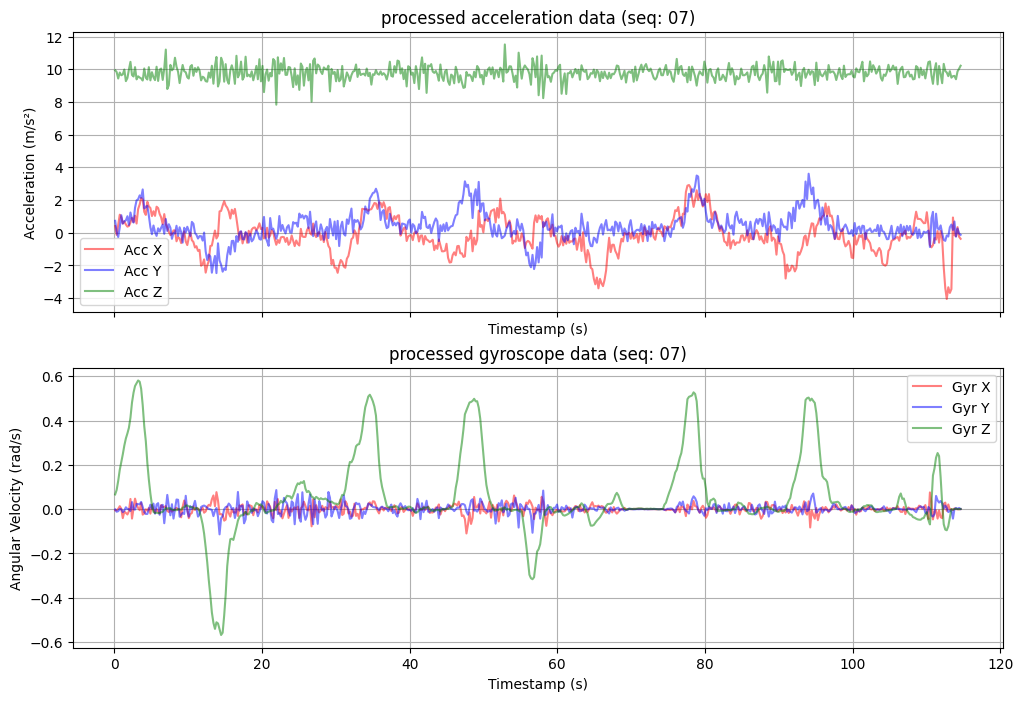

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ts = imu['time'].values
axs[0].plot(ts, imu['acc_x'], label='Acc X', color='red', alpha=0.5)
axs[0].plot(ts, imu['acc_y'], label='Acc Y', color='blue', alpha=0.5)
axs[0].plot(ts, imu['acc_z'], label='Acc Z', color='green', alpha=0.5)
axs[0].set_title(f'processed acceleration data (seq: 07)')
axs[0].set_xlabel('Timestamp (s)')
axs[0].set_ylabel('Acceleration (m/s²)')
axs[0].grid()
axs[0].legend()

axs[1].plot(ts, imu['gyro_x'], label='Gyr X', color='red', alpha=0.5)
axs[1].plot(ts, imu['gyro_y'], label='Gyr Y', color='blue', alpha=0.5)
axs[1].plot(ts, imu['gyro_z'], label='Gyr Z', color='green', alpha=0.5)
axs[1].set_title(f'processed gyroscope data (seq: 07)')
axs[1].set_xlabel('Timestamp (s)')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].grid()
axs[1].legend()

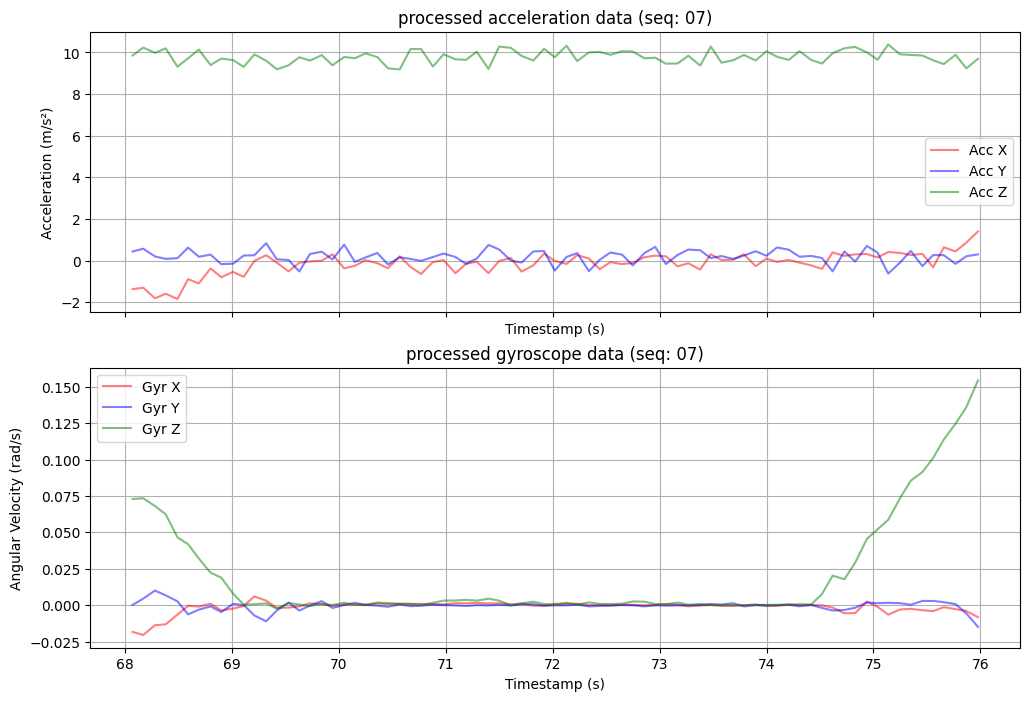

In [30]:
condition = raw_imu['time'] < 76.0
condition &= raw_imu['time'] > 68.0

temp_df = raw_imu[condition]
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ts = temp_df['time'].values
axs[0].plot(ts, temp_df['acc_x'], label='Acc X', color='red', alpha=0.5)
axs[0].plot(ts, temp_df['acc_y'], label='Acc Y', color='blue', alpha=0.5)
axs[0].plot(ts, temp_df['acc_z'], label='Acc Z', color='green', alpha=0.5)
axs[0].set_title(f'processed acceleration data (seq: 07)')
axs[0].set_xlabel('Timestamp (s)')
axs[0].set_ylabel('Acceleration (m/s²)')
axs[0].grid()
axs[0].legend()

axs[1].plot(ts, temp_df['gyro_x'], label='Gyr X', color='red', alpha=0.5)
axs[1].plot(ts, temp_df['gyro_y'], label='Gyr Y', color='blue', alpha=0.5)
axs[1].plot(ts, temp_df['gyro_z'], label='Gyr Z', color='green', alpha=0.5)
axs[1].set_title(f'processed gyroscope data (seq: 07)')
axs[1].set_xlabel('Timestamp (s)')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].grid()
axs[1].legend()

When I plot acceleration and gyroscope data in the interval that the estimation goes wrong, the gyroscope records zero for several seconds, which may causes the error of wrong estimation? 

#### VO data

In [39]:
vo_columns = ['timestamp', 'time', 'vo_dt']
vo_relative_pose_columns = ['vo_0', 'vo_1', 'vo_2', 'vo_3', 'vo_4', 'vo_5', 'vo_6', 'vo_7', 'vo_8', 'vo_9', 'vo_10', 'vo_11']
vo_columns += vo_relative_pose_columns
raw_vo = raw_df[raw_df['type'] == "KITTI_VO"][vo_columns]
vo = df[df['type'] == "KITTI_VO"][vo_columns]

In [48]:
# Get vo estimated velocity
# Camera frame is x: rightward, y: downward, z: forward

# Get the estimated velocity in m/s 
raw_vo[['vo_vel_x', 'vo_vel_y', 'vo_vel_z']] = raw_vo[vo_relative_pose_columns].values.reshape(-1, 3, 4)[:, :3, 3] / raw_vo['vo_dt'].values.reshape(-1, 1)
vo[['vo_vel_x', 'vo_vel_y', 'vo_vel_z']] = vo[vo_relative_pose_columns].values.reshape(-1, 3, 4)[:, :3, 3] / vo['vo_dt'].values.reshape(-1, 1)

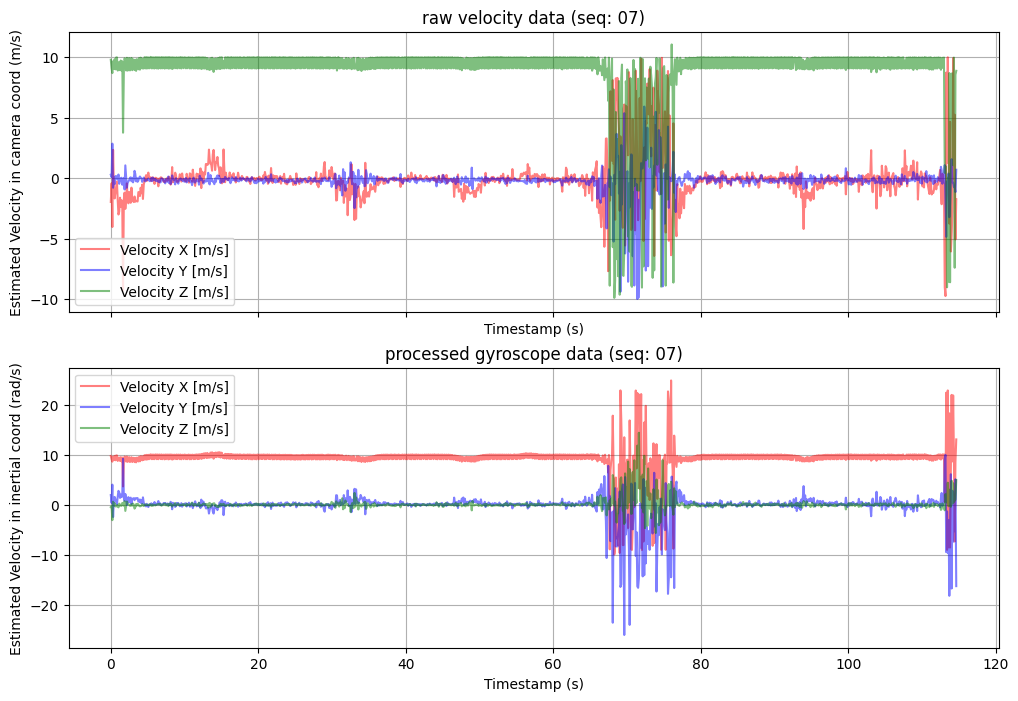

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ts = vo['time'].values
axs[0].plot(ts, raw_vo['vo_vel_x'], label='Velocity X [m/s]', color='red', alpha=0.5)
axs[0].plot(ts, raw_vo['vo_vel_y'], label='Velocity Y [m/s]', color='blue', alpha=0.5)
axs[0].plot(ts, raw_vo['vo_vel_z'], label='Velocity Z [m/s]', color='green', alpha=0.5)
axs[0].set_title(f'raw velocity data (seq: 07)')
axs[0].set_xlabel('Timestamp (s)')
axs[0].set_ylabel('Estimated Velocity in camera coord (m/s)')
axs[0].grid()
axs[0].legend()

axs[1].plot(ts, vo['vo_vel_x'], label='Velocity X [m/s]', color='red', alpha=0.5)
axs[1].plot(ts, vo['vo_vel_y'], label='Velocity Y [m/s]', color='blue', alpha=0.5)
axs[1].plot(ts, vo['vo_vel_z'], label='Velocity Z [m/s]', color='green', alpha=0.5)
axs[1].set_title(f'processed gyroscope data (seq: 07)')
axs[1].set_xlabel('Timestamp (s)')
axs[1].set_ylabel('Estimated Velocity in inertial coord (rad/s)')
axs[1].grid()
axs[1].legend()

It clearly shows that the VO estimated velocity provides wrong values from 68 to 78 seconds.

In [59]:
R = np.eye(3)
rotation_raw = []
for _R in raw_vo[vo_relative_pose_columns].values.reshape(-1, 3, 4)[:, :3, :3]:
    R = R @ _R
    rotation_raw.append(State.get_euler_angle_from_rotation_matrix(R))
rotation_raw = np.array(rotation_raw)

R = np.eye(3)
rotation = []
for _R in vo[vo_relative_pose_columns].values.reshape(-1, 3, 4)[:, :3, :3]:
    R = R @ _R
    rotation.append(State.get_euler_angle_from_rotation_matrix(R))
rotation = np.array(rotation)


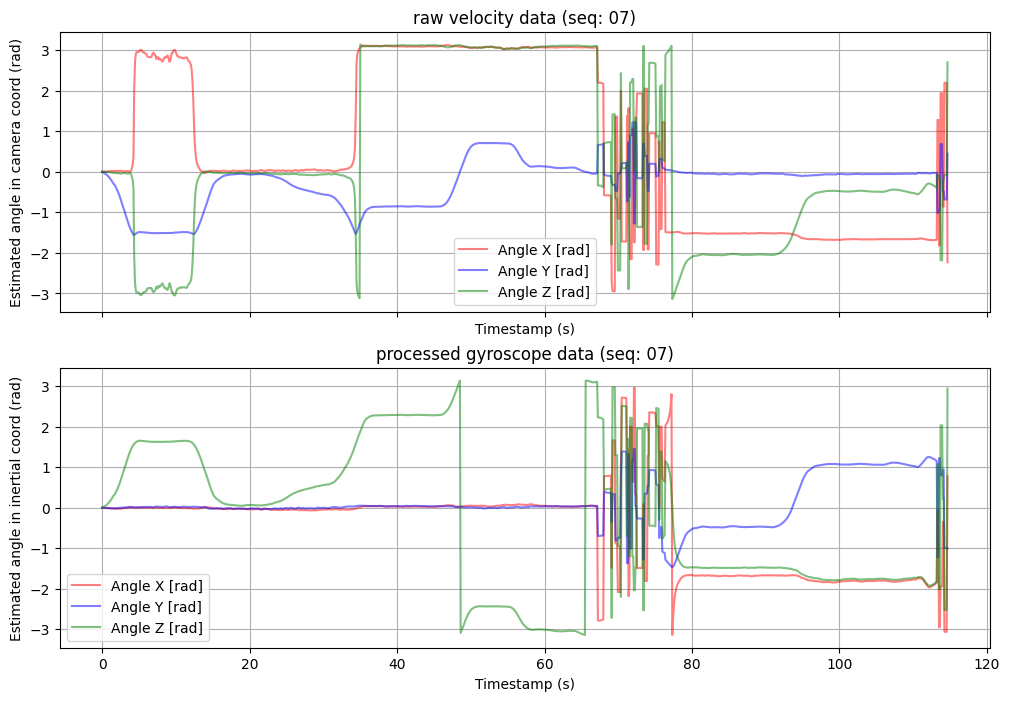

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ts = vo['time'].values
euler_x, euler_y, euler_z = rotation_raw[:, 0], rotation_raw[:, 1], rotation_raw[:, 2]
axs[0].plot(ts, euler_x, label='Angle X [rad]', color='red', alpha=0.5)
axs[0].plot(ts, euler_y, label='Angle Y [rad]', color='blue', alpha=0.5)
axs[0].plot(ts, euler_z, label='Angle Z [rad]', color='green', alpha=0.5)
axs[0].set_title(f'raw velocity data (seq: 07)')
axs[0].set_xlabel('Timestamp (s)')
axs[0].set_ylabel('Estimated angle in camera coord (rad)')
axs[0].grid()
axs[0].legend()

euler_x, euler_y, euler_z = rotation[:, 0], rotation[:, 1], rotation[:, 2]
axs[1].plot(ts, euler_x, label='Angle X [rad]', color='red', alpha=0.5)
axs[1].plot(ts, euler_y, label='Angle Y [rad]', color='blue', alpha=0.5)
axs[1].plot(ts, euler_z, label='Angle Z [rad]', color='green', alpha=0.5)
axs[1].set_title(f'processed gyroscope data (seq: 07)')
axs[1].set_xlabel('Timestamp (s)')
axs[1].set_ylabel('Estimated angle in inertial coord (rad)')
axs[1].grid()
axs[1].legend()

In [55]:
condition = vo['time'] < 76.0
condition &= vo['time'] > 68.0

vo[condition]

,timestamp,time,vo_dt,vo_0,vo_1,vo_2,vo_3,vo_4,vo_5,vo_6,vo_7,vo_8,vo_9,vo_10,vo_11,vo_vel_x,vo_vel_y,vo_vel_z
1311,1.317376e+09,68.068557,0.099996,-0.365849,0.917192,-0.157836,1.777150,0.916520,0.325601,-0.232325,-2.354427,-0.161696,-0.229656,-0.959746,0.591431,17.772241,-23.545248,5.914551
1313,1.317376e+09,68.178549,0.109992,0.999950,-0.008440,0.005368,0.810079,0.008433,0.999964,0.001345,-0.137817,-0.005379,-0.001300,0.999985,0.565800,7.364889,-1.252976,5.144011
1315,1.317376e+09,68.278745,0.100196,0.999974,-0.007174,0.000604,-0.995144,0.007173,0.999974,0.000697,-0.154247,-0.000609,-0.000693,1.000000,-0.012209,-9.931962,-1.539448,-0.121848
1317,1.317376e+09,68.388530,0.109785,0.999975,-0.007075,0.000160,-0.931817,0.007075,0.999974,-0.001399,0.363231,-0.000150,0.001400,0.999999,0.070035,-8.487662,3.308568,0.637929
1319,1.317376e+09,68.488541,0.100011,0.999959,-0.008929,-0.001625,0.542983,0.008930,0.999960,0.000340,-0.833756,0.001622,-0.000355,0.999999,-0.142394,5.429230,-8.336629,-1.423781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.317376e+09,75.558387,0.100018,-0.931445,0.330662,0.151897,2.261398,0.325917,0.572455,0.752379,-1.778923,0.161829,0.750305,-0.640979,0.374697,22.609906,-17.786029,3.746295
1457,1.317376e+09,75.668380,0.109993,0.228497,0.888640,0.397627,2.289921,0.886432,-0.358779,0.292432,-1.609148,0.402528,0.285650,-0.869699,0.456112,20.818790,-14.629549,4.146737
1459,1.317376e+09,75.768676,0.100296,0.999839,-0.017902,-0.001063,0.841819,0.017903,0.999839,0.000793,-0.537428,0.001049,-0.000812,0.999999,-0.024683,8.393349,-5.358420,-0.246105
1461,1.317376e+09,75.878318,0.109642,0.999863,-0.016443,-0.001826,0.929416,0.016444,0.999865,0.000310,0.316173,0.001821,-0.000340,0.999998,0.002862,8.476818,2.883685,0.026103


Based on debugged frames from 0000000655.png to 0000000731.png, the vehicle is stopping and the other cars passed by the vehicle causing the error of the estimation!!

0000000665.png:
<img src="/Volumes/Data_EXT/data/workspaces/sensor_fusion/data/KITTI/2011_09_30/2011_09_30_drive_0027_sync/image_00/data/0000000665.png" height=300 width=600 />

0000000731.png:
<img src="/Volumes/Data_EXT/data/workspaces/sensor_fusion/data/KITTI/2011_09_30/2011_09_30_drive_0027_sync/image_00/data/0000000731.png" height=300 width=600 />